In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import measure, color

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# For Stardist
import tensorflow as tf
print(tf.__version__)
layers = tf.keras.layers
from csbdeep.utils import normalize
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

# prints a list of available models 
StarDist2D.from_pretrained() 

2.3.0
There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [3]:
# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [4]:
# Functions to acces image

# Img data: location and name
path = "../data/"
options = [["RPE1wt_CEP152+GTU88+PCNT_1","DAPI","CEP152","GTU88","PCNT"], #Channel:0 ; subchannel:0,1,2,3
           ["RPE1wt_CEP63+CETN2+PCNT_1","DAPI","CEP63","CETN2","PCNT"], #Channel:1 ; subchannel:0,1,2,3
           ["RPE1wt_CP110+GTU88+PCNT_2","DAPI","CP110","GTU88","PCNT"]] #Channel:2 ; subchannel:0,1,2,3


def generatePaths(channel, id_, format_="tif", path=path):
    """ Generate 4 paths and title of sample """
    
    # generate path strings
    paths = [(path + 
            options[channel][0] + "/" +
            options[channel][C] + "/" +
            format_ + "/" +
            options[channel][0] +
            "_00" + str(id_[0]) + "_00" + str(id_[1]) + "_max_C" + str(C-1) +
            "." + format_)
            for C in range(1,5)]
    
    # generate main_title
    main_title = options[channel][0] +"_00" + str(id_[0]) + "_00" + str(id_[1])
    
    return paths, main_title

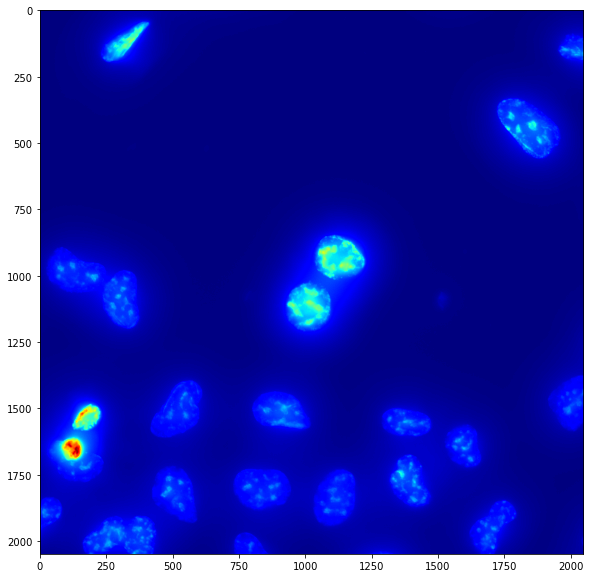

In [5]:
# Which sample ?
channel = 1
id_ = [4,2]

# Import DAPI
mypath = generatePaths(channel,id_)[0][0]
raw = plt.imread(mypath, cv.IMREAD_UNCHANGED)
raw = raw.astype(float)

# Display it
plt.imshow(raw,cmap='jet')
plt.show()

In [6]:
# Compute gradients in x and y directions using the Sobel mask
grad_x = cv.Sobel(raw,ddepth=-1,dx=1,dy=0,ksize=31)
grad_y = cv.Sobel(raw,ddepth=-1,dx=0,dy=1,ksize=31)
grad_mag = np.sqrt(np.power(grad_x,2) + np.power(grad_y,2))
grad_scaled = grad_mag/np.max(grad_mag)*np.max(raw)

# Store pictures
images = [grad_scaled, grad_scaled+raw, raw]

# Scale them for Stardist use
resized = [cv.resize(image, (256,256)) for image in images]

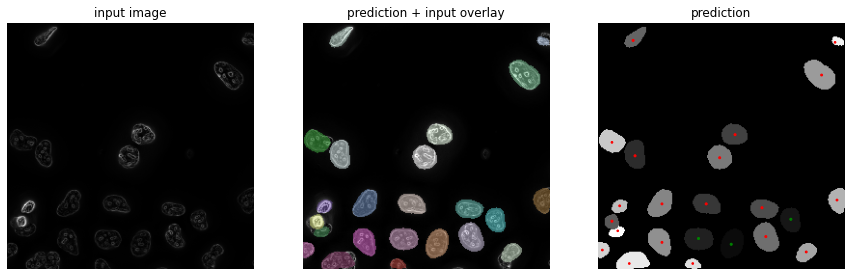

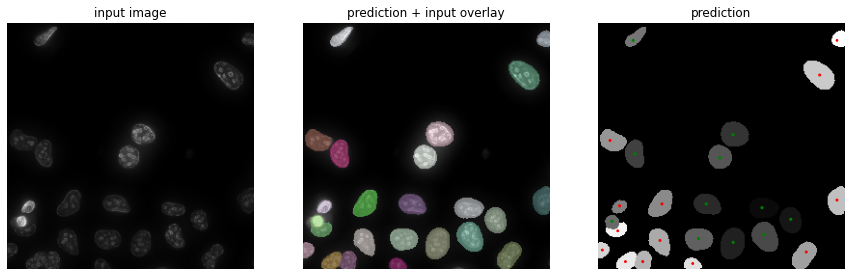

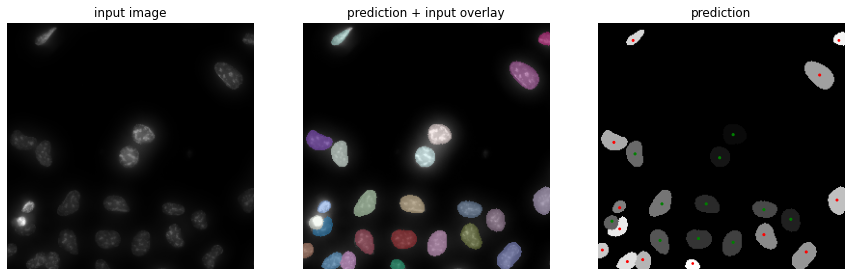

In [7]:
# Create list to store Stardist's label output
stack = []

# Compute output and display it
for idx,img in enumerate(resized):
    
    tags = np.arange(idx*3+1, idx*3+4)
    
    labels, infos = model.predict_instances(normalize(img))
    points = infos['points']
    prob = infos['prob']
    coord = infos['coord']
    
    plt.figure(figsize=(15,20))

    plt.subplot(3,3,tags[0])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title("input image")

    plt.subplot(3,3,tags[1])
    plt.imshow(render_label(labels, img=img))
    plt.axis("off")
    plt.title("prediction + input overlay")

    plt.subplot(3,3,tags[2])
    plt.imshow(labels,cmap='gray')
    plt.scatter(points[:,1],points[:,0],s=prob*5,color= ['green' if pro>0.85 else 'red' for pro in prob])
    plt.axis("off")
    plt.title("prediction")
    
    stack.append(labels)
    
    plt.show()

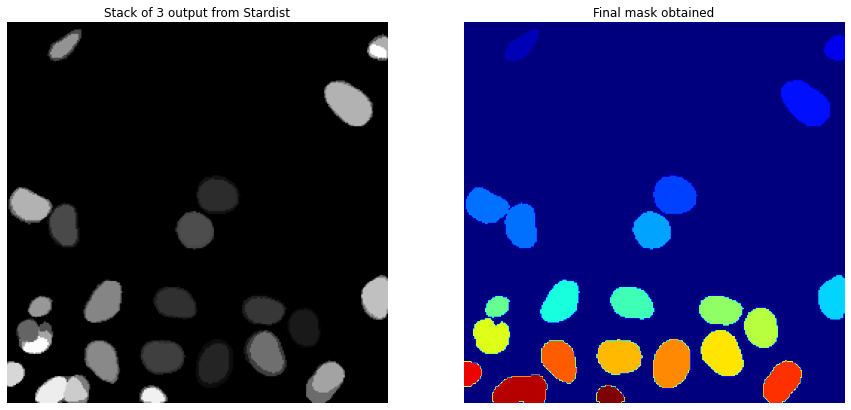

In [8]:
# Create one attention mask from Stack list
attention = np.sum(np.array(stack),axis = 0)

# Merge connected labels and count them
blobs = measure.label(attention>1)

# Show result
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(attention)
plt.title("Stack of 3 output from Stardist")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(blobs,cmap='jet')
plt.title("Final mask obtained")
plt.axis("off")

plt.show()

In [9]:
# Add 50 pixels border to: resized raw input, obtained attention mask, output of Stardist when input is: resized raw input
add = 50

input_ = cv.copyMakeBorder(resized[2], add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
mask = cv.copyMakeBorder(blobs, add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])
output = cv.copyMakeBorder(labels, add, add, add, add, cv.BORDER_CONSTANT, value=[0, 0, 0])

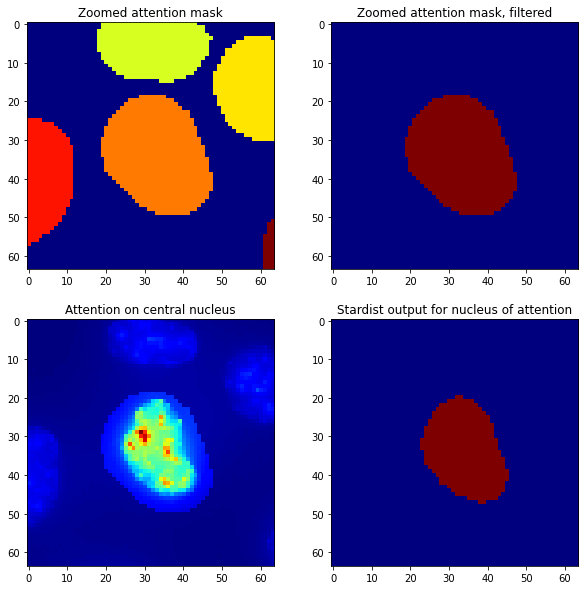

In [10]:
# Show example on 9th nucleus found by stardist
i = 12

# Offset
x,y = points[i,0]+add, points[i,1]+add

# Half size of picture
e = 32

# Zoom on point location
crop = mask[x-e:x+e,y-e:y+e]
nuc = input_[x-e:x+e,y-e:y+e]
out = output[x-e:x+e,y-e:y+e]

# Get value at center of picture for attention mask and Stardist output
nuc_mag = crop[32,32]
out_mag = out[32,32]

# Keep only area where value is the same
nuc = nuc*((crop == nuc_mag) + 0.25*(crop!=nuc_mag).astype(int))
out = out*(out==out_mag)

# Show result
plt.subplot(2,2,1)
plt.imshow(crop,cmap='jet')
plt.title('Zoomed attention mask')

plt.subplot(2,2,2)
plt.imshow(crop == nuc_mag,cmap='jet')
plt.title('Zoomed attention mask, filtered')

plt.subplot(2,2,3)
plt.imshow(nuc,cmap='jet')
plt.title('Attention on central nucleus')

plt.subplot(2,2,4)
plt.imshow(out,cmap='jet')
plt.title('Stardist output for nucleus of attention')
        
plt.show()